# Carga de datos

In [1]:
import os
import cv2
import numpy as np

def getImages(directorio, size=(256,256)):
    datos = []
    etiquetas = []
    for etiqueta, clase in enumerate(["fumador", "noFumador"]):
        pathClass = os.path.join(directorio, clase)
        for img in os.listdir(pathClass):
            imgPath = os.path.join(pathClass, img)
            imagen = cv2.imread(imgPath)
            if imagen is not None: 
                imagen = cv2.resize(imagen, size)
                datos.append(imagen)
                etiquetas.append(etiqueta)
    return (np.array(datos), np.array(etiquetas))

datos, etiquetas = getImages("data")

In [2]:
noFumadores = datos[etiquetas == 1]
fumadores = datos[etiquetas == 0]

print("No fumadores: ", noFumadores.shape)
print("Fumadores: ", fumadores.shape)

No fumadores:  (1276, 256, 256, 3)
Fumadores:  (1969, 256, 256, 3)


In [3]:
# Paso 2: Separar las clases
datos_fumadores = datos[etiquetas == 0]
etiquetas_fumadores = etiquetas[etiquetas == 0]

datos_no_fumadores = datos[etiquetas == 1]
etiquetas_no_fumadores = etiquetas[etiquetas == 1]

In [4]:
# Paso 3: Definir el número de muestras (tamaño mínimo de ambas clases)
n_samples = min(len(datos_fumadores), len(datos_no_fumadores))

In [5]:
# Paso 4: Reducir ambas clases al tamaño mínimo (undersampling)
from sklearn.utils import resample
datos_fumadores_reducidos, etiquetas_fumadores_reducidos = resample(
    datos_fumadores,
    etiquetas_fumadores,
    replace=False,
    n_samples=n_samples,
    random_state=42
)

In [6]:
datos_no_fumadores_reducidos, etiquetas_no_fumadores_reducidos = resample(
    datos_no_fumadores,
    etiquetas_no_fumadores,
    replace=False,
    n_samples=n_samples,
    random_state=42
)

In [7]:
# Paso 5: Concatenar los datos balanceados
datos = np.concatenate((datos_fumadores_reducidos, datos_no_fumadores_reducidos))
etiquetas = np.concatenate((etiquetas_fumadores_reducidos, etiquetas_no_fumadores_reducidos))

In [8]:

# Paso 6: Verificar el tamaño de cada clase
noFumadores = datos[etiquetas == 1]
fumadores = datos[etiquetas == 0]

In [9]:
print("No fumadores: ", noFumadores.shape)
print("Fumadores: ", fumadores.shape)

No fumadores:  (1276, 256, 256, 3)
Fumadores:  (1276, 256, 256, 3)


In [10]:
datos = datos / 255.0

# Dividir los datos

In [11]:
from sklearn.model_selection import train_test_split
# Dividir datos en entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_val, y_train, y_val = train_test_split(
    datos, 
    etiquetas, 
    test_size=0.2, 
    random_state=42
)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Cargar el modelo base preentrenado
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelar las capas del modelo base

# Añadir capas personalizadas para la clasificación binaria
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Definir el modelo
model = Model(inputs=base_model.input, outputs=predictions)

2024-10-18 20:56:12.823952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 20:56:13.005354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 20:56:13.053396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 20:56:12.930991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 20:56:15.067275: W tensorflow/compiler/tf2

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
import tensorflow as tf

# Verificar si hay GPUs disponibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU(s) disponible(s): {len(gpus)}")
else:
    print("No se detectaron GPUs.")

GPU(s) disponible(s): 1


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir un callback para detener el entrenamiento si no mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)

2024-10-18 20:56:27.730159: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1605107712 exceeds 10% of free system memory.
2024-10-18 20:56:31.568023: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1605107712 exceeds 10% of free system memory.


Epoch 1/20


I0000 00:00:1729306596.678615   25692 service.cc:146] XLA service 0x7fe9740107a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729306596.679102   25692 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-10-18 20:56:36.832544: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-18 20:56:37.696291: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729306600.562708   25692 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306600.791754   25692 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Sys

 2/32 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5586 - loss: 0.6765 

I0000 00:00:1729306606.382399   25692 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7333 - loss: 0.5346

E0000 00:00:1729306609.508198   25689 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306609.730675   25689 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306611.379572   25689 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306611.714018   25689 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-18 20:56:58.883166: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[57,384,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[57,64,16,16]{3,2,1,0}, f32[

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7359 - loss: 0.5313

2024-10-18 20:56:55.838732: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 401866752 exceeds 10% of free system memory.
2024-10-18 20:56:56.507851: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 401866752 exceeds 10% of free system memory.
2024-10-18 20:57:08.897617: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=3,k3=0} for conv (f32[63,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[63,32,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-18 20:57:09.052824: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The oper

32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 748ms/step - accuracy: 0.7370 - loss: 0.5297 - val_accuracy: 0.7945 - val_loss: 0.4442
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8480 - loss: 0.3593 - val_accuracy: 0.8160 - val_loss: 0.4370
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8904 - loss: 0.2780 - val_accuracy: 0.8160 - val_loss: 0.4134
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8781 - loss: 0.2699 - val_accuracy: 0.8160 - val_loss: 0.4195
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9404 - loss: 0.1891 - val_accuracy: 0.8121 - val_loss: 0.4177
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9484 - loss: 0.1730 - val_accuracy: 0.8200 - val_loss: 0.4319
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9705 - loss: 0.1346 - val_accuracy: 0.8082 - val_loss: 0.4479
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9834 - loss: 0.0994 - val_accuracy: 0.8102 - val_loss: 

In [17]:
model.save('v1.keras')

In [18]:
model.save('v1.h5')

# Cargar el modelo

In [38]:
import tensorflow as tf

In [39]:
modeloGuardado = tf.keras.models.load_model('v1.keras')

In [40]:
modeloGuardado.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

# Probar el modelo cargado

In [41]:

import cv2
import numpy as np

def predecir_fumador(ruta_imagen, modelo):
    # Cargar la imagen desde la ruta especificada
    imagen = cv2.imread(ruta_imagen)
    
    if imagen is None:
        print(f"No se pudo cargar la imagen en {ruta_imagen}. Asegúrate de que la ruta sea correcta.")
        return
    
    # Preprocesar la imagen: redimensionar y normalizar
    imagen = cv2.resize(imagen, (256, 256))  # Redimensionar al tamaño esperado por el modelo
    imagen = imagen / 255.0  # Normalizar al rango [0, 1]
    imagen = np.expand_dims(imagen, axis=0)  # Añadir una dimensión para representar el batch (1, 256, 256, 3)

    # Realizar la predicción
    prediccion = modelo.predict(imagen)
    
    # Interpretar la predicción
    if prediccion[0][0] > 0.5:
        resultado = "No fumador"
    else:
        resultado = "Fumador"
    
    # Mostrar el resultado
    print(f"Resultado de la predicción para la imagen {ruta_imagen}: {resultado}")
    return resultado

In [42]:
fumador = 'data/fumador/000-0.jpg'
nofumador = 'data/noFumador/000296.jpg'

predecir_fumador(nofumador, modeloGuardado)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Resultado de la predicción para la imagen data/noFumador/000296.jpg: Fumador


'Fumador'

# Métricas

In [43]:
import os
import cv2
import numpy as np

def getImages(directorio, size=(256,256)):
    datos = []
    etiquetas = []
    for etiqueta, clase in enumerate(["fumador", "noFumador"]):
        pathClass = os.path.join(directorio, clase)
        for img in os.listdir(pathClass):
            imgPath = os.path.join(pathClass, img)
            imagen = cv2.imread(imgPath)
            if imagen is not None: 
                imagen = cv2.resize(imagen, size)
                datos.append(imagen)
                etiquetas.append(etiqueta)
    return (np.array(datos), np.array(etiquetas))

# Cargar los datos
datos, etiquetas = getImages("data")

# Normalizar los datos
datos = datos / 255.0

from sklearn.model_selection import train_test_split

# Dividir datos en entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_val, y_train, y_val = train_test_split(
    datos, 
    etiquetas, 
    test_size=0.2, 
    random_state=42
)

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step
Reporte de Clasificación:
               precision    recall  f1-score   support

     Fumador       0.92      0.93      0.93       428
  No Fumador       0.87      0.85      0.86       221

    accuracy                           0.91       649
   macro avg       0.90      0.89      0.89       649
weighted avg       0.91      0.91      0.91       649



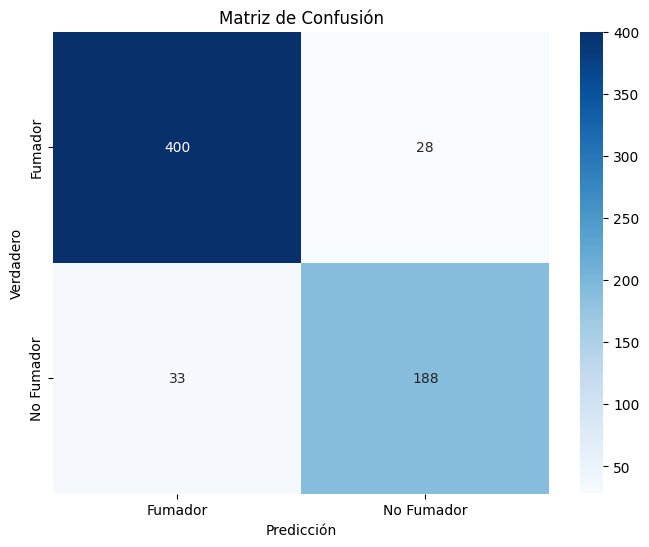

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecir las probabilidades en los datos de validación
predicciones_proba = modeloGuardado.predict(X_val)

# Convertir probabilidades en etiquetas (umbral = 0.5)
predicciones = (predicciones_proba > 0.5).astype(int).flatten()

# Generar el reporte de clasificación
reporte = classification_report(y_val, predicciones, target_names=["Fumador", "No Fumador"])
print("Reporte de Clasificación:\n", reporte)

# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_val, predicciones)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=["Fumador", "No Fumador"], yticklabels=["Fumador", "No Fumador"])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Saliency Maps

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model

# Clase 0: Fumador, Clase 1: No Fumador
score = CategoricalScore([0])  # Cambia entre [0] y [1] para diferentes clases

gradcam = Gradcam(modeloGuardado, model_modifier=None, clone=False)

def generar_saliency_map(ruta_imagen, modelo, score, gradcam):
    # Cargar y preprocesar la imagen
    imagen = cv2.imread(ruta_imagen)
    imagen = cv2.resize(imagen, (256, 256)) / 255.0
    imagen = np.expand_dims(imagen, axis=0)

    # Generar el mapa de Grad-CAM
    saliency_map = gradcam(score, imagen)
    
    # Visualización
    plt.imshow(imagen[0])
    plt.imshow(saliency_map[0], cmap='jet', alpha=0.5)  # Superponer mapa de calor
    plt.title("Mapa de Grad-CAM")
    plt.axis('off')
    plt.show()

# Prueba con una imagen
generar_saliency_map("data/fumador/000-0.jpg", modeloGuardado, score, gradcam)


LookupError: gradient registry has no entry for: shap_Mean

# SHAP Values

In [ ]:
import shap

# Seleccionar un conjunto pequeño de imágenes para la interpretación
imagenes_para_shap = X_val[:10]

# Crear el objeto DeepExplainer
explainer = shap.DeepExplainer(modeloGuardado, imagenes_para_shap)

# Calcular los valores SHAP para una imagen específica
shap_values = explainer.shap_values(imagenes_para_shap)

# Visualizar los valores SHAP para la primera imagen
shap.image_plot(shap_values, imagenes_para_shap)

/home/angel/DL-Proyecto/myenv/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/home/angel/DL-Proyecto/myenv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=['*']
  warnings.warn(
W0000 00:00:1730944818.719510    1236 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730944818.721760    1236 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730944818.722778    1236 gpu_timer.cc

StagingError: in user code:

    File "/home/angel/DL-Proyecto/myenv/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 269, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_Relu6
